# Pipe3: 
## To classify location of damage - front, rear or behind.

In [1]:
import os
import urllib.request
import h5py
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter 
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, History
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1

Using TensorFlow backend.


In [3]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [4]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1, ', val_acc:', model_hist['val_acc'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

In [5]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist['acc'], label='Training')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
    
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout();
    
    print("Best Model:")
    print_best_model_results(hist)

In [27]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0]*(416) + [1]*(288) + [2]*(272))
    train_labels = to_categorical(train_labels)
    
    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(73) + [1]*(53) + [2]*(50))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
        
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model,fit.history

In [7]:
def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))
    
    top_model.load_weights(top_model_weights_path)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history

In [8]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    pred_labels = [0 if i<0.5 else 1 for i in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

## Image dataset details

In [12]:
location = 'data3'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'
model1 = location+'/bottleneck_fc_model.h5'
train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 976
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 176

img_width, img_height = 256,256
epochs = 50
batch_size = 16

In [6]:
save_bottleneck_features()

Found 976 images belonging to 3 classes.
Found 176 images belonging to 3 classes.


In [28]:
d3_model, d3_history = train_categorical_model()

Train on 976 samples, validate on 176 samples
Epoch 1/50
976/976 [==============================] - 10s 10ms/step - loss: 9.3856 - acc: 0.3596 - val_loss: 8.1843 - val_acc: 0.4205

Epoch 00001: val_acc improved from -inf to 0.42045, saving model to data3/top_model_weights.h5
Epoch 2/50
976/976 [==============================] - 9s 9ms/step - loss: 7.9106 - acc: 0.4375 - val_loss: 7.3149 - val_acc: 0.4489

Epoch 00002: val_acc improved from 0.42045 to 0.44886, saving model to data3/top_model_weights.h5
Epoch 3/50
976/976 [==============================] - 9s 10ms/step - loss: 4.8074 - acc: 0.4867 - val_loss: 1.0958 - val_acc: 0.6193

Epoch 00003: val_acc improved from 0.44886 to 0.61932, saving model to data3/top_model_weights.h5
Epoch 4/50
976/976 [==============================] - 9s 10ms/step - loss: 1.3619 - acc: 0.5707 - val_loss: 0.8674 - val_acc: 0.6307

Epoch 00004: val_acc improved from 0.61932 to 0.63068, saving model to data3/top_model_weights.h5
Epoch 5/50
976/976 [=========


Epoch 00042: val_acc did not improve from 0.76136
Epoch 43/50
976/976 [==============================] - 13s 14ms/step - loss: 0.1377 - acc: 0.9703 - val_loss: 3.1824 - val_acc: 0.6705

Epoch 00043: val_acc did not improve from 0.76136
Epoch 44/50
976/976 [==============================] - 11s 12ms/step - loss: 0.1243 - acc: 0.9723 - val_loss: 2.7411 - val_acc: 0.6932

Epoch 00044: val_acc did not improve from 0.76136
Epoch 45/50
976/976 [==============================] - 11s 11ms/step - loss: 0.1840 - acc: 0.9570 - val_loss: 2.4528 - val_acc: 0.7159

Epoch 00045: val_acc did not improve from 0.76136
Epoch 46/50
976/976 [==============================] - 10s 11ms/step - loss: 0.1444 - acc: 0.9734 - val_loss: 2.3951 - val_acc: 0.7330

Epoch 00046: val_acc did not improve from 0.76136
Epoch 47/50
976/976 [==============================] - 10s 10ms/step - loss: 0.1249 - acc: 0.9734 - val_loss: 2.5522 - val_acc: 0.7614

Epoch 00047: val_acc did not improve from 0.76136
Epoch 48/50
976/976

ValueError: too many values to unpack (expected 2)

Best Model:
epoch: 14 , val_acc: 0.75 , val_loss: 1.011548800901933


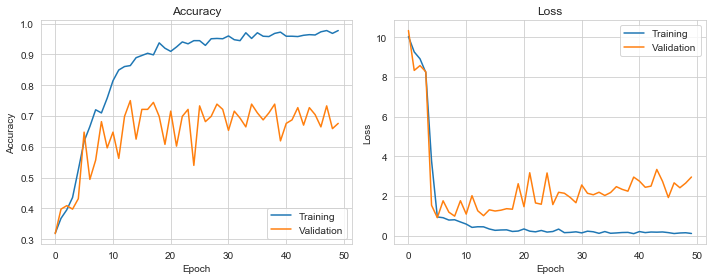

In [29]:
plot_metrics(d3_history)

In [30]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Found 976 images belonging to 3 classes.
Found 176 images belonging to 3 classes.
Epoch 1/50
61/61 [==============================] - 828s 14s/step - loss: 1.1973 - acc: 0.8145 - val_loss: 1.9150 - val_acc: 0.7614

Epoch 00001: val_acc improved from -inf to 0.76136, saving model to data3/ft_model.h5
Epoch 2/50
 6/61 [=>............................] - ETA: 9:30 - loss: 1.3216 - acc: 0.7812

KeyboardInterrupt: 

In [18]:
ft_model = load_model('data3/bottleneck_fc_model.h5')

ValueError: Cannot create group in read only mode.

In [52]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [53]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

Found 176 images belonging to 3 classes.


KeyboardInterrupt: 

## Pipe3.1

In [16]:
def pipe31(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'Front', 1:'Rear', 2:'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:",d[key])
    print("Severity assessment complete.")

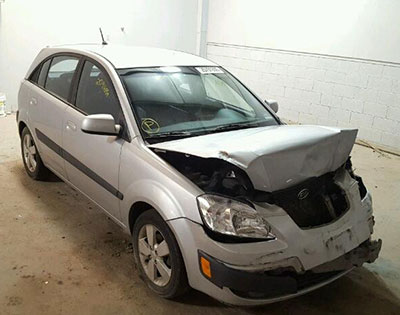

In [76]:
Image('https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg')

In [24]:
pipe31('https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg', model1)

AttributeError: 'str' object has no attribute 'predict'

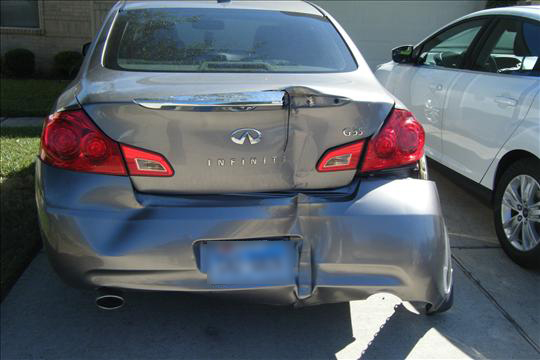

In [81]:
Image('https://drndata.com/wp-content/uploads/2016/03/car.jpg')

In [82]:
pipe31('https://drndata.com/wp-content/uploads/2016/03/car.jpg', ft_model)

Validating location of damage....Result: Rear
Severity assessment complete.


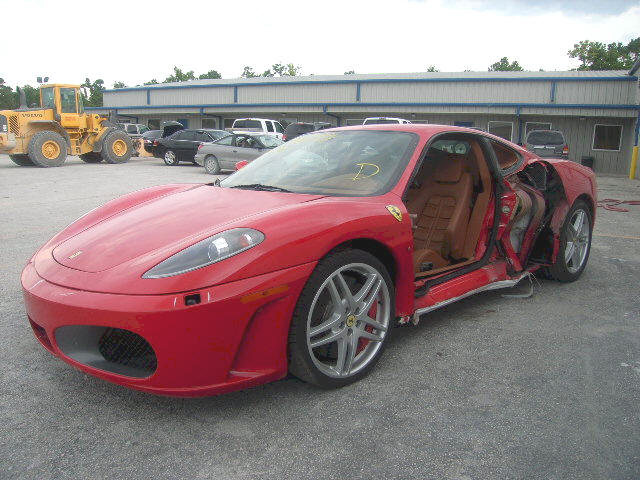

In [90]:
Image('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg')

In [91]:
pipe31('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg', ft_model)

Validating location of damage....Result: Side
Severity assessment complete.
